In [ ]:
%config InlineBackend.figure_formats = ['svg']
import os

STATIC_WEB_PAGE = {"EXECUTE_NB", "READTHEDOCS"}.intersection(os.environ)

```{autolink-concat}
```

# [TR-001] Custom lambdification

:::{note}

This report has been implemented in {pr}`ComPWA/ampform#72` and {pr}`ComPWA/tensorwaves#284`.

:::

:::{seealso}

{doc}`SymPy's tutorial page on the printing modules <sympy:modules/printing>`

:::

<!-- cspell:disable -->

In [ ]:
%pip install -q black==21.5b2 jax==0.2.13 jaxlib==0.1.67 matplotlib==3.4.2 numpy==1.19.5 sympy==1.8

In [ ]:
import inspect
from typing import Any

import jax
import jax.numpy as jnp
import numpy as np
import sympy as sp
from black import FileMode, format_str

## Overwrite printer methods

As noted in {doc}`/report/000`, it's hard to lambdify a {func}`sympy.sqrt <sympy.functions.elementary.miscellaneous.sqrt>` to {doc}`JAX <jax:index>`. One possible way out is to define a custom class that derives from {class}`sympy.Expr <sympy.core.expr.Expr>` and {doc}`overwrite its printer methods <sympy:modules/printing>`.

In [ ]:
from sympy.printing.printer import Printer


class ComplexSqrt(sp.Expr):
    def __new__(cls, x, *args: Any, **kwargs: Any):
        x = sp.sympify(x)
        expr = sp.Expr.__new__(cls, x, *args, **kwargs)
        if hasattr(x, "free_symbols") and not x.free_symbols:
            return expr.evaluate()
        return expr

    def evaluate(self):
        x = self.args[0]
        if not x.is_real:
            return sp.sqrt(x)
        return sp.Piecewise(
            (sp.I * sp.sqrt(-x), x < 0),
            (sp.sqrt(x), True),
        )

    def _latex(self, printer: Printer, *args: Any) -> str:
        x = printer._print(self.args[0])
        return fR"\sqrt[\mathrm{{c}}]{{{x}}}"

    def _numpycode(self, printer: Printer, *args: Any) -> str:
        printer.module_imports["numpy.lib"].add("scimath")
        x = printer._print(self.args[0])
        return f"scimath.sqrt({x})"

    def _pythoncode(self, printer: Printer, *args: Any) -> str:
        printer.module_imports["cmath"].add("sqrt as csqrt")
        x = printer._print(self.args[0])
        return f"csqrt({x})"

As opposed to the {doc}`derivation of a sympy.Expr </adr/002/expr>`, this class evaluates directly, because the `evaluate` key-word argument is not used processed by the `__new__` method:

In [ ]:
ComplexSqrt(-4)

2*I

The `_latex()` method ensures that `ComplexSqrt` renders nicely in notebooks:

In [ ]:
x = sp.Symbol("x")
ComplexSqrt(x)

ComplexSqrt(x)

## Plot custom class

In addition, one may modify this `Lambdifier` class, so that {func}`sympy.plot() <sympy.plotting.plot.plot>` also works on this custom class:

In [ ]:
from sympy.plotting.experimental_lambdify import Lambdifier

Lambdifier.builtin_functions_different["ComplexSqrt"] = "sqrt"

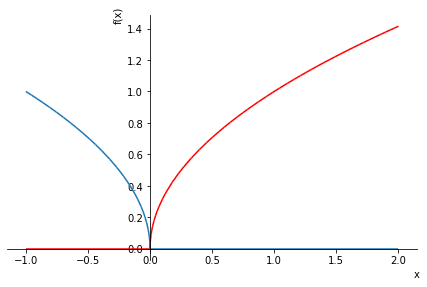

In [ ]:
x = sp.Symbol("x")
expr = ComplexSqrt(x)
p1 = sp.plot(sp.re(expr), (x, -1, 2), show=False, line_color="red")
p2 = sp.plot(sp.im(expr), (x, -1, 2), show=False)
p1.append(p2[0])
p1.show()

## Lambdifying

The important part, lambdifying to {mod}`numpy` or {mod}`math` works well as well now:

In [ ]:
lambdified_py = sp.lambdify(x, ComplexSqrt(x), "math")
source = inspect.getsource(lambdified_py)
print(source)

def _lambdifygenerated(x):
    return (csqrt(x))



In [ ]:
numpy_lambdified = sp.lambdify(x, ComplexSqrt(x), "numpy")
source = inspect.getsource(numpy_lambdified)
print(source)

def _lambdifygenerated(x):
    return (scimath.sqrt(x))



In [ ]:
sample = np.linspace(-1, +1, 5)
numpy_lambdified(sample)

array([0.        +1.j        , 0.        +0.70710678j,
       0.        +0.j        , 0.70710678+0.j        ,
       1.        +0.j        ])

Just as noted in {ref}`report/000:Complex square root` though, {mod}`numpy.lib.scimath` is not provided by the NumPy API of {doc}`JAX <jax:index>`. As discussed there, we can at most decorate the {mod}`numpy.lib.scimath` version with {func}`jax.jit` and work with static arguments only:

In [ ]:
jax_lambdified = jax.jit(numpy_lambdified, backend="cpu", static_argnums=0)
jax_lambdified(-1)

DeviceArray(0.+1.j, dtype=complex64)

In that case, unhashable (non-static) input samples are still not accepted:

In [ ]:
jax_lambdified(sample)

ValueError: Non-hashable static arguments are not supported. An error occured while trying to hash an object of type <class 'numpy.ndarray'>, [-1.  -0.5  0.   0.5  1. ]. The error was:
TypeError: unhashable type: 'numpy.ndarray'


## Handle for JAX

As concluded in {ref}`report/000:Conditional square root`, the alternative to lambdify to {mod}`numpy.lib.scimath` is to lambdify to {func}`numpy.select`. This has some caveats, though, like that you should not use `__dict__`. Worse, JAX is not immediately supported as backend. Fortunately, we now know how to overwrite lambdify methods.

An additional tool we need now is to {doc}`define a new printer class <sympy:modules/printing>` for JAX, so that we can also define a special rendering method for `ComplexSqrt` in the case of JAX. Most of its printing methods should be the same as that of SymPy's `NumPyPrinter`, the rest we can overwrite:

:::{note}

Alternative would be to add a method `_jaxcode` to the `ComplexSqrt` class above. See {doc}`sympy:modules/printing`.

:::

In [ ]:
from sympy.printing.numpy import NumPyPrinter


class JaxPrinter(NumPyPrinter):
    _module = "jax"

    def _print_ComplexSqrt(self, expr: sp.Expr) -> str:
        arg = expr.args[0]
        x = self._print(arg)
        return (
            f"select([less({x}, 0), True], [1j * sqrt(-{x}), sqrt({x})],"
            " default=nan,)"
        )

In [ ]:
numpy_expr = sp.lambdify(x, ComplexSqrt(x), modules=np, printer=JaxPrinter)
source = inspect.getsource(numpy_expr)

In [ ]:
print(format_str(source, mode=FileMode()))

def _lambdifygenerated(x):
    return select(
        [less(x, 0), True],
        [1j * sqrt(-x), sqrt(x)],
        default=nan,
    )



In [ ]:
jax_expr = sp.lambdify(x, ComplexSqrt(x), modules=jnp, printer=JaxPrinter)
source = inspect.getsource(jax_expr)

In [ ]:
print(format_str(source, mode=FileMode()))

def _lambdifygenerated(x):
    return select(
        [less(x, 0), True],
        [1j * sqrt(-x), sqrt(x)],
        default=nan,
    )



In [ ]:
jax_expr(sample)

DeviceArray([0.        +1.j        , 0.        +0.70710677j,
             0.        +0.j        , 0.70710677+0.j        ,
             1.        +0.j        ], dtype=complex64)

The lambdified function can of course also be decorated with {func}`jax.jit`:

In [ ]:
jit_expr = jax.jit(jax_expr)

### Performance check

In [ ]:
sample = np.random.normal(size=1_000_000)
jax_sample = jnp.array(sample)

In [ ]:
%timeit jit_expr(jax_sample)

1.91 ms ± 116 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%timeit jax_expr(jax_sample)

6.31 ms ± 42.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%timeit numpy_expr(sample)

<lambdifygenerated-3>:2: RuntimeWarning: invalid value encountered in sqrt
  return (select([less(x, 0), True], [1j * sqrt(-x), sqrt(x)], default=nan,))


16.9 ms ± 614 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
